# House Prices Prediction

In [391]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy.stats.distributions import randint, uniform

In [392]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('train.csv')

In [3]:
dfe = df.copy().set_index('Id')

**Target**: Sale Price

## Numerical Features

In [4]:
num_cols = dfe.dtypes[(dfe.dtypes != 'object')].index

In [5]:
dfe_num = dfe[num_cols].copy()

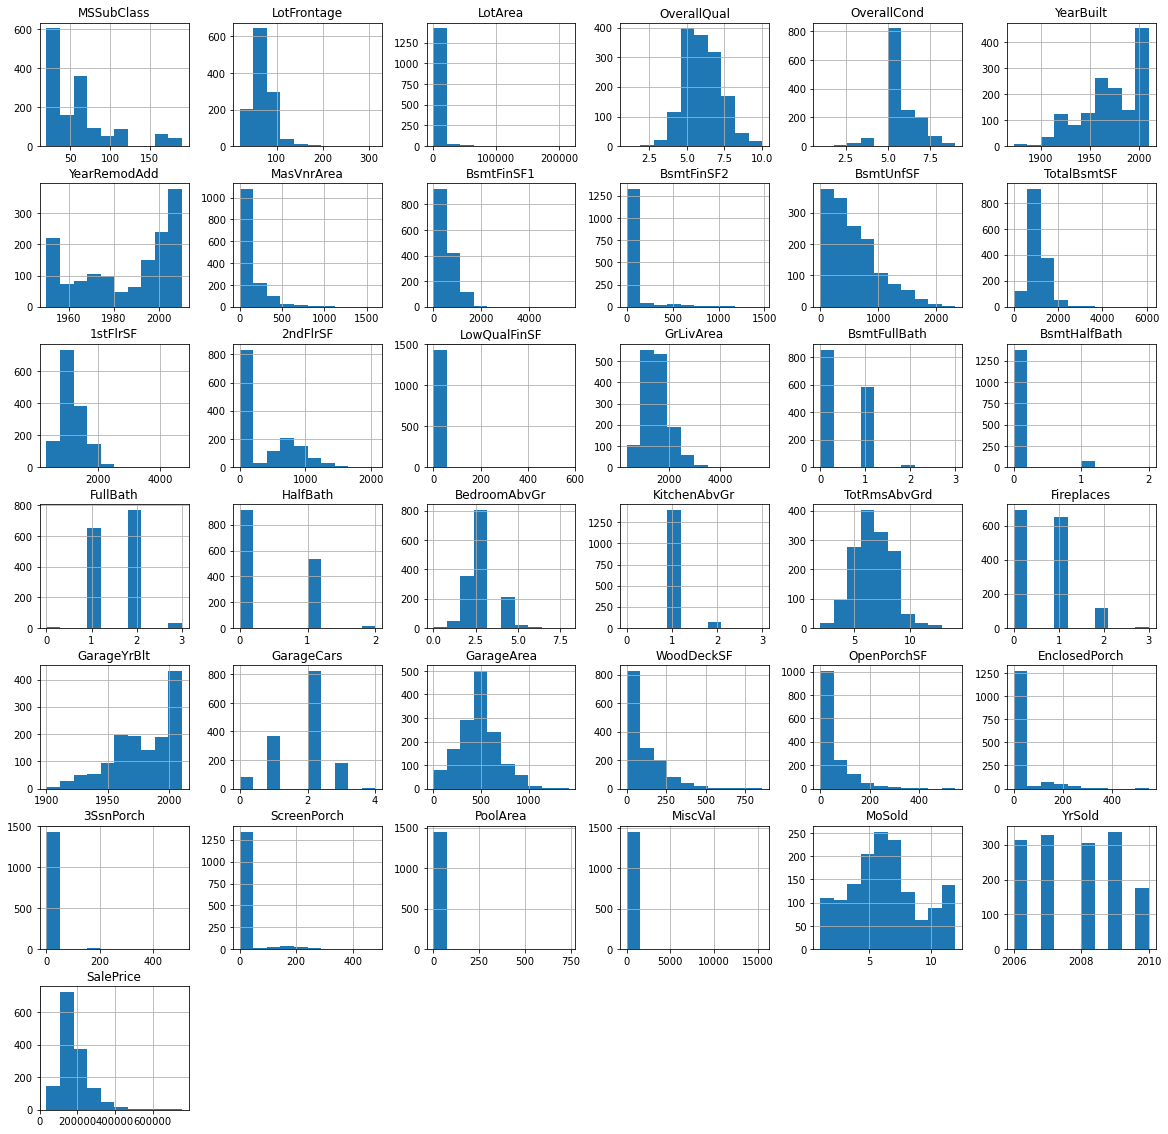

In [6]:
dfe_num.hist(figsize=(20,20))
plt.show()

In [7]:
num_corr = dfe_num.corrwith(dfe_num['SalePrice'], method='pearson').sort_values(ascending=False)

In [8]:
pd.concat([num_corr, dfe_num.count()], axis=1, keys=['Correlation', 'N'])[1:]

,Correlation,N
OverallQual,0.790982,1460
GrLivArea,0.708624,1460
GarageCars,0.640409,1460
GarageArea,0.623431,1460
TotalBsmtSF,0.613581,1460
1stFlrSF,0.605852,1460
FullBath,0.560664,1460
TotRmsAbvGrd,0.533723,1460
YearBuilt,0.522897,1460
YearRemodAdd,0.507101,1460


### To do

* Understand different concepts used in real estate. Above grade, second and first floor. Type 1, type 2 basement
* **GrLivArea (Area Above Ground)**: Maybe it is correlated with other measures, evaluate if it is worth keeping
* **GarageCars and GarageArea**: Evaluate if there is redundancy, seems highly correlated
* Investigate how above grade features are correlated with each other, maybe it is possible to reduce dimensionality
* Investigate how basement features are correlated with each other, maybe it is possible to reduce dimensionality
* YearBuilt, GarageYrBuilt (Some missing values) and YearRemodAdd are the same on many instances see if it is possible to create better features using them
* Lotfrontage (Missing values)
* **MoSold**: Although it is represented as an integer, the month sold is actually categorical. Perform OneHotEnconding
* Investigate how to treat MiscVal, since it addresses different things
* MSSubClass: Is actually categorical. Perform OneHotEnconding
* Investigate how square feet relate with each other, maybe it is possible to reduce dimensionality
* See if it is possible to merge FullBathrooms and HalfBathrooms into a single variable
* How to treat variables which have many zero values, such as the different types of porch

-------------
#### Domain knowledge

According to https://www.appraisalpartners.com/how-appraisers-determine-gross-living-area/
* **Gross living area (GLA)** is the finished, livable area above ground. Which means the garage and basement are not taken into account. This is the variable (GrLivArea)
* *The distinction beteween **Area Above Ground** and **Area below ground** is made because their square feet don't have the same impact on the final price*


For pratical effects, the GLA usually is equal to the 1st Floor SF + 2nd Floor SF

In [9]:
np.mean(dfe_num['GrLivArea'] == (dfe_num['1stFlrSF'] + dfe_num['2ndFlrSF']))

0.9821917808219178

* So, often: **GrlivArea = 1stFlrSF + 2ndFlrSF**

I couldn't understand completely what's the difference bewtween a type 1 and type 2 basement. It seems there is this distinction just in case a house has more than one basement.


* It always holds that: **TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF**

In [10]:
np.mean(dfe_num['TotalBsmtSF'] == (dfe_num['BsmtFinSF1'] + dfe_num['BsmtFinSF2'] + dfe_num['BsmtUnfSF']))

1.0

--------
**GarageCars** and **GarageArea** are highly correlated

In [11]:
dfe_num[['GarageCars']].corrwith(dfe_num['GarageArea'], method='pearson')

GarageCars    0.882475
dtype: float64

Maybe it is worth dropping **GarageArea**, this option will be put in the preparation pipeline

-----------------
**YrSold** is not highly correlated with the **SalePrice**, which seems resonable, because it ranges from 2006 to 2010, there is not much variability. Maybe due to the economy houses had different values on a given year, so YrSold could be treated as categorical. Let's check that.


In [12]:
dfe_num.groupby(by=['YrSold'])['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
YrSold,,,,,,,,
2006,314.0,182549.458599,79426.838855,35311.0,131375.0,163995.0,218782.5,625000.0
2007,329.0,186063.151976,85768.171410,39300.0,129900.0,167000.0,219500.0,755000.0
2008,304.0,177360.838816,69735.610685,40000.0,131250.0,164000.0,207000.0,446261.0
2009,338.0,179432.103550,80879.237311,34900.0,125250.0,162000.0,212750.0,582933.0
2010,175.0,177393.674286,80451.280085,55000.0,128100.0,155000.0,213250.0,611657.0


The relationship is not very clear, but I'll put the encoding option on the preparation Pipeline

----------------------
**YearBuilt**, **GarageYearBuilt** and **YearRemodAdd** often have the same value, because:

* If the Garage was built with the house, **GarageYearBuilt == YearBuilt**
* If the house wasn't Remodeled, **YearBuilt == YearRemod**

Obs: If the house doesn't have a garage, then **GarageYearBuilt** receives NA

A good transformation to perform is to replace those features with **YrSold - feature**, the new feature stores how old that transformation is mesaured in years, there is a scale now.


In [13]:
dfe_num[['YrSold', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].corrwith(dfe_num['SalePrice']).sort_values(ascending=False)

YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
YrSold         -0.028923
dtype: float64

In [14]:
dfe_num['House_Age'] = dfe_num['YrSold'] - dfe_num['YearBuilt']
dfe_num['Remod_Age'] = dfe_num['YrSold'] - dfe_num['YearRemodAdd']
dfe_num['Garage_Age'] = dfe_num['YrSold'] - dfe_num['GarageYrBlt']

In [15]:
dfe_num[['House_Age', 'Remod_Age', 'Garage_Age']].corrwith(dfe_num['SalePrice']).sort_values(ascending=True)

House_Age    -0.523350
Remod_Age    -0.509079
Garage_Age   -0.487069
dtype: float64

* Also, will create a new feature which is the mean of **House_Age** and **Remod_Age**

In [16]:
dfe_num['Score_Old'] = (dfe_num['House_Age'] + dfe_num['Remod_Age'])/2

In [17]:
dfe_num[['Score_Old']].corrwith(dfe_num['SalePrice'])

Score_Old   -0.577091
dtype: float64

The correlation increases in module

**GarageYrBuilt** has missing values and doesn't contain much information compared to **House_Age** and **Remod_Age**. It is resonable to drop this column

-----------------------
**LotFrontage** has many missing values. My guess it is NA if the dwelling is not connected by streets


In [18]:
dfe_num[['LotFrontage']].fillna(0).corrwith(dfe_num['SalePrice'])

LotFrontage    0.209624
dtype: float64

Filling with zero just make things worse. I suppose knowing if a house is connected by streets doesn't give much information. This column will be dropped.

----------
**MoSold** is categorical


<AxesSubplot:xlabel='MoSold'>

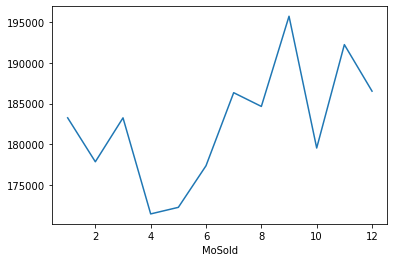

In [19]:
dfe_num.groupby(by=['MoSold'])['SalePrice'].mean().plot()

---------
For this prototipe, **MiscVal** will be dropped

------------
**MSSubClass** is categorical

<AxesSubplot:xlabel='MSSubClass'>

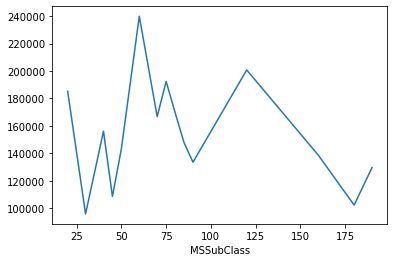

In [20]:
dfe_num.groupby(by=['MSSubClass'])['SalePrice'].mean().plot()

Perform OneHotEncoding

----------
Treating **FullBathrooms** and **HalfBathrooms**

In [21]:
dfe_num[['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']].corrwith(dfe_num['SalePrice'])

FullBath        0.560664
HalfBath        0.284108
BsmtFullBath    0.227122
BsmtHalfBath   -0.016844
dtype: float64

**BsmtHalfBath** is not correlated with **SalePrice**, it is a candidate for being dropped

In [22]:
p1 = 2
p2 = 1
dfe_num['TotBath_score'] = (p1*dfe_num['FullBath'] + p2*dfe_num['HalfBath'])/(p1+p2)
dfe_num['BsmtTotBath_score'] = (p1*dfe_num['BsmtFullBath'] + p2*dfe_num['BsmtHalfBath'])/(p1+p2)

Creating a score for the number of bathrooms, givin weight two for a **FullBath** and one for **HalfBath**, the correlation increseas on the above ground features

In [23]:
dfe_num[['TotBath_score', 'BsmtTotBath_score']].corrwith(dfe_num['SalePrice'])

TotBath_score        0.597966
BsmtTotBath_score    0.224953
dtype: float64

--------------
Features with a lot of zeros

In [24]:
dfe_num[['MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea', '3SsnPorch', 'EnclosedPorch']].describe()

,MasVnrArea,WoodDeckSF,OpenPorchSF,PoolArea,3SsnPorch,EnclosedPorch
count,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,103.685262,94.244521,46.660274,2.758904,3.409589,21.954110
std,181.066207,125.338794,66.256028,40.177307,29.317331,61.119149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000
75%,166.000000,168.000000,68.000000,0.000000,0.000000,0.000000
max,1600.000000,857.000000,547.000000,738.000000,508.000000,552.000000


In [25]:
dfe_num[['MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea', '3SsnPorch', 'EnclosedPorch']].corrwith(dfe_num['SalePrice'])

MasVnrArea       0.477493
WoodDeckSF       0.324413
OpenPorchSF      0.315856
PoolArea         0.092404
3SsnPorch        0.044584
EnclosedPorch   -0.128578
dtype: float64

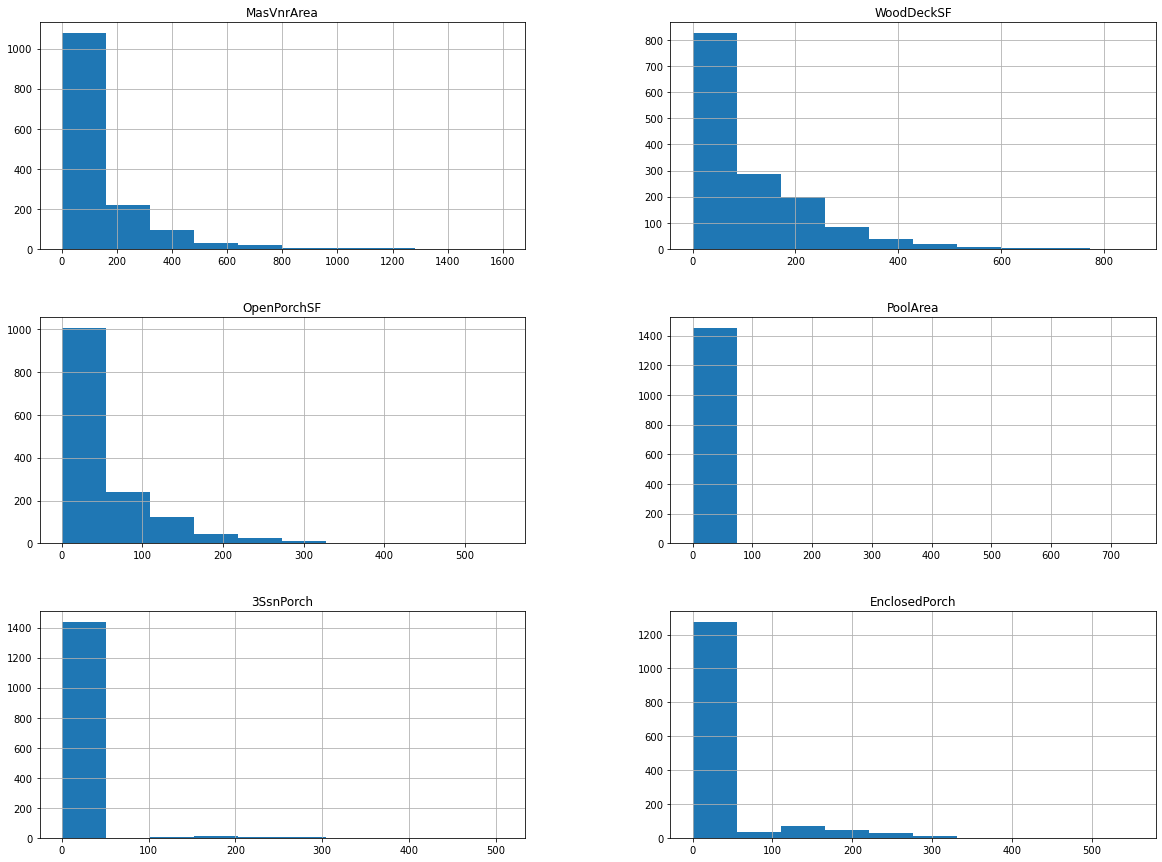

In [26]:
dfe_num[['MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea', '3SsnPorch', 'EnclosedPorch']].hist(figsize=(20,15))
plt.show()

In [27]:
sum(dfe_num['PoolArea'] != 0), sum(dfe_num['3SsnPorch'] != 0)

(7, 24)

**PoolArea** and **3SsnPorch** have few nonzero instances. They should be dropped.

**MasVnrArea** has 8 missing values. They will be filled with the mean

----------
**LowQualFinSF** is poorly correlated with **SalePrice**, it is a candidate for dropping

-------
### **Summary**

#### Necessary
* Columns to drop: **LotFrontage (Missing Vals), GarageYrBlt (Missing Vals)**
* Transformations:
    + House_Age = YrSold - YearBuilt
    + Remod_Age = YrSold - YearRemodAdd
* Fill Missing:
    + Fill *MasVnrArea* NAs with its mean (8 missing)

#### Optional
* Columns to drop: **MiscVal, LowQualFinSF, BsmtFinSF2, BsmtHalfBath, 3SsnPorch, PoolArea** 
* Column selection:
    + Keep **GrLivArea** instead of **1stFlrSF and 2stFlrSF**
    + Keep **TotalBsmtSF** instead of **BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF**
    + Drop either **Garage Cars** or **Garage Area**
    + Drop **MoSold**
* Scores:
    + Score_Age = (House_Age + Remod_Age)/2
    + Tot_Bath_Score = (2xFullBath + 1xHalfBath)/2

#### Necessary Encoding (It is not a numerical feature)
* Categoricals:
    + **MoSold**: OneHotEncoding
    + **MSSubClass**: OneHotEncoding

In [28]:
class Basic_Transf_Num(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.MasVnrMean = X['MasVnrArea'].mean()
        return self
    def transform(self, X, y=None):
        Xt = X.copy().drop(['LotFrontage', 'GarageYrBlt'], axis=1)
        Xt['MasVnrArea'] = Xt['MasVnrArea'].fillna(self.MasVnrMean)
        Xt['House_Age'] = Xt['YrSold'] - Xt['YearBuilt']
        Xt['Remod_Age'] = Xt['YrSold'] - Xt['YearRemodAdd']
        Xt = Xt.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'], axis=1)
        return Xt

In [429]:
class Drops_Num(BaseEstimator, TransformerMixin):
    def __init__(self, misc_val=True, low_qual=True, bsmt2=True, half_bsmt=True, porch3=True, pool=True):
        self.misc_val = misc_val
        self.low_qual = low_qual
        self.bsmt2 = bsmt2
        self.half_bsmt = half_bsmt
        self.porch3 = porch3
        self.pool = pool
        self.cols = np.array(['MiscVal', 'LowQualFinSF', 'BsmtFinSF2','BsmtHalfBath', '3SsnPorch', 'PoolArea'])
    def fit(self, X, y=None):
        self.drops = np.array([self.misc_val, self.low_qual, self.bsmt2, self.half_bsmt, self.porch3,self.pool])
        self.col_drops = self.cols[self.drops]
        return self
    def transform(self, X, y=None):
        Xt = X.copy().drop(self.col_drops, axis=1)
        return Xt

In [430]:
class ColumnSelector_Num(BaseEstimator, TransformerMixin):
    def __init__(self, just_grliv=True, just_bsmt_tot_area=True, just_cars=True):
        self.just_grliv = just_grliv
        self.just_bsmt_tot_area = just_bsmt_tot_area
        self.just_cars = just_cars
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xt = X.copy()
        if self.just_grliv:
            Xt = Xt.drop(['1stFlrSF', '2ndFlrSF'], axis=1)
        if self.just_bsmt_tot_area:
            Xt = Xt.drop(['BsmtFinSF1', 'BsmtUnfSF'], axis=1)
            if 'BsmtFinSF2' in Xt.columns:
                Xt = Xt.drop(['BsmtFinSF2'], axis=1)
        if self.just_cars:
            Xt = Xt.drop(['GarageCars'], axis=1)
        return Xt

In [431]:
class Scorer_Num(BaseEstimator, TransformerMixin):
    def __init__(self, score_age=True, score_bath=True):
        self.score_age = score_age
        self.score_bath = score_bath
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xt = X.copy()
        if self.score_age:
            Xt['Score_Age'] = (Xt['House_Age'] + Xt['Remod_Age'])/2
            Xt = Xt.drop(['House_Age', 'Remod_Age'], axis=1)
        elif self.score_bath:
            Xt['Score_Bath'] = (2*Xt['FullBath'] + 1*Xt['HalfBath'])/3
            Xt = Xt.drop(['FullBath', 'HalfBath'], axis=1)
        return Xt

### Predictions using just Numerical Features

Just out of curiosity, I'll test a model using just numerical features to predict the price of a house. To measure the improvement so far.

I tried a couple of things beforehand and concluded that:
* It is better to drop those columns that were suspected to be useless.
* It is better to drop **MoSold** and keep **MSSubClass** as it is, but I'll drop **MSSubClass** too because it is not numerical
* Extra Trees (Like a Random Forest but more random) performed better than Random Forest.


In [432]:
pre_pipe_num = Pipeline([
    ('Basic_Transf', Basic_Transf_Num()),
    ('Drops', Drops_Num()),
    ('ColumnSelect', ColumnSelector_Num()),
    ('Scorer', Scorer_Num()),
    ('Impute_Missing_Num', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
])

In [33]:
num_cols = dfe.dtypes[(dfe.dtypes != 'object')].index.drop(['SalePrice', 'MoSold', 'MSSubClass'])
X = df[num_cols].copy()
y = df['SalePrice'].copy().ravel()

In [34]:
pipe_predict_num = Pipeline([
    ('Preprocess', pre_pipe_num),
    ('Predict', ExtraTreesRegressor(n_jobs=-1, random_state=42))
])

In [423]:
para_grid_num = {
    'Preprocess__ColumnSelect__just_grliv':[False, True],
    'Preprocess__ColumnSelect__just_bsmt_tot_area':[False, True],
    'Preprocess__ColumnSelect__just_cars':[False, True],
    
    'Preprocess__Scorer__score_age':[False, True],
    'Preprocess__Scorer__score_bath':[False, True]
}

In [424]:
grid_exRF_num = RandomizedSearchCV(pipe_predict_num, para_grid, cv=5, scoring='neg_mean_squared_error',n_iter=32)

In [425]:
grid_exRF_num.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocess',
                                              Pipeline(steps=[('Basic_Transf',
                                                               Basic_Transf_Num()),
                                                              ('Drops',
                                                               Drops_Num()),
                                                              ('ColumnSelect',
                                                               ColumnSelector_Num()),
                                                              ('Scorer',
                                                               Scorer_Num()),
                                                              ('Impute_Missing',
                                                               SimpleImputer(strategy='median')),
                                                              ('Scaler',
                                   

In [436]:
grid_exRF_num.best_score_

-798855972.2246398

In [437]:
grid_exRF_num.best_params_

{'Preprocess__Scorer__score_bath': False,
 'Preprocess__Scorer__score_age': True,
 'Preprocess__ColumnSelect__just_grliv': False,
 'Preprocess__ColumnSelect__just_cars': False,
 'Preprocess__ColumnSelect__just_bsmt_tot_area': False}

In [438]:
best_exRF_num = grid_exRF_num.best_estimator_

In [35]:
def write_test(mod, name, cols):
    df_t = pd.read_csv('test.csv')
    df_pred = pd.concat([df_t.Id, pd.Series(mod.predict(df_t[cols]), name='SalePrice')], axis=1)
    df_pred.to_csv(name, index=False)

In [441]:
write_test(best_exRF_num, 'ExtraTrees_only_num.csv', num_cols)

This model reaches Top 48%, scoring -0.1405 (neg_mean_squared_log_error). Still a long way to go.

Comparing to a dummy model which always predicts the mean

In [202]:
-mean_squared_error(df['SalePrice'], [df['SalePrice'].mean() for i in range(len(df))])

-6306788585.349299

In [203]:
-mean_squared_log_error(df['SalePrice'], [df['SalePrice'].mean() for i in range(len(df))])

-0.16613594413479232

*The predictor using numerical features outperforms the dummy model*

## Categorical Features

In [34]:
cat_cols = dfe.dtypes[(dfe.dtypes == 'object')].index

In [35]:
dfe_cat = dfe[cat_cols].copy()

In [36]:
dfe_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

Dealing with categorical features is different than numerical features. A couple of things to do:

### To do
* Figure out if MSSubClass code mean something. Whether it is ordinal or nominall
* Distinguish ordinal features from nominal features.
* On Ordinal features, decide the order of levels and then OrdinalEncode
* On Nominal Features, use OneHotEncode
* On Nominal Features, figure out a way to reduce the number of levels on those features with many levels
* Decide which Features can be dropped
* Figure out how to treat unknown categories
* How to treat missing values

I'll treat Ordinal Features first, since they are easier to deal with.

### Ordinal Features

First it is necessary to identified the ordinal features, the order of their levels, if there is missing values or missing categories.

In [37]:
ord_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Street', 'Alley',
               'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

In [38]:
df[ord_features].describe().T

,count,unique,top,freq
LotShape,1460,4,Reg,925
Utilities,1460,2,AllPub,1459
LandSlope,1460,3,Gtl,1382
ExterQual,1460,4,TA,906
ExterCond,1460,5,TA,1282
BsmtQual,1423,4,TA,649
BsmtCond,1423,4,TA,1311
BsmtExposure,1422,4,No,953
BsmtFinType1,1423,6,Unf,430
BsmtFinType2,1422,6,Unf,1256


The levels of the features are at the data description file. When a house doesn't have the thing which the feature refers to, missing data is often inserted. Knowing that, I'll encode NA as 0.

In [42]:
pipe_encode = ColumnTransformer([
    ('Encode_Qual', OrdinalEncoder(categories=[['NA', 'Po', 'Fa','TA','Gd', 'Ex'] for i in range(10)]), 
     ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageQual', 'GarageCond',
     'PoolQC']),
    ('Encode_Lot_Shape', OrdinalEncoder(categories=[['NA','Reg', 'IR1', 'IR2', 'IR3']]), ['LotShape']),
    ('Encode_Utilities', OrdinalEncoder(categories=[['NA','ELO', 'NoSeWa', 'NoSewr', 'AllPub']]), ['Utilities']),
    ('Encode_Land_Slope', OrdinalEncoder(categories=[['NA','Gtl', 'Mod', 'Sev']]), ['LandSlope']),
    ('Encode_BsmtExposure', OrdinalEncoder(categories=[['NA','No','Mn','Av','Gd']]), ['BsmtExposure']),
    ('Encode_BsmtFin', OrdinalEncoder(categories=[['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'] for i in range(2)]), 
     ['BsmtFinType1', 'BsmtFinType2']),
    ('Encode_Binary', OrdinalEncoder(), ['Street', 'Alley', 'CentralAir']),
    ('Encode_PavedDrive', OrdinalEncoder(categories=[['NA','N', 'P', 'Y']]), ['PavedDrive']),
    ('Encode_Fence', OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]), ['Fence'])
])

In [43]:
class Impute_NA(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.fillna('NA')

In [44]:
freq_max_features = df[ord_features].describe().T['freq']

In [45]:
class Col_Drop(TransformerMixin, BaseEstimator):
    def __init__(self, trim_top=1000, trim_low=200):
        self.trim_top = trim_top
        self.trim_low = trim_low
        self.new_order = ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageQual', 'GarageCond',
     'PoolQC', 'LotShape', 'Utilities', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Street', 
    'Alley', 'CentralAir','PavedDrive', 'Fence']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xt = pd.DataFrame(X, columns=self.new_order)
        col_drop = freq_max_features.index[((freq_max_features > self.trim_top) | (freq_max_features < self.trim_low)).ravel()]
        return Xt.drop(col_drop, axis=1).values

In [365]:
pre_pipe_ordinal = Pipeline([
    ('Impute_Missing_Ord', Impute_NA()),
    ('Encode_Ordinal', pipe_encode),
    ('Ord_Select', Col_Drop())]
)

### Predictions using just Ordinal Features and Numerical Features

In [247]:
num_ord_transformer = ColumnTransformer([
    ('Num', pre_pipe_num, num_cols),
    ('Ord', pre_pipe_ordinal, ord_features)
])

In [363]:
pred_num_ord = Pipeline([
    ('Pre', num_ord_transformer),
    ('Predict', ExtraTreesRegressor(n_jobs=-1, random_state=42))
])

In [248]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice'].values.ravel()

In [249]:
cross_val_score(pred_num_ord, X, y, cv=10, scoring='neg_mean_squared_log_error').mean()

-0.019963716153845016

In [241]:
def write_test(mod,name):
    df_t = pd.read_csv('test.csv')
    df_pred = pd.concat([df_t.Id, pd.Series(mod.predict(df_t), name='SalePrice')], axis=1)
    df_pred.to_csv(name, index=False)

In [242]:
mod_num_ord = pred_num_ord.fit(X,y)

In [245]:
write_test(grid_search.best_estimator_, 'ExtraNumOrdSelectedMostDropped.csv')

### Nominal Features

When dealing with Nominal features, the most common option is to OneHotEncode. But this would add too much sparsity to the data and too many features resulting in curse of dimensionality. The dimensionality is a point to consider since the train data is small, just 14960 rows. I'll use a different type of encoding.

In [342]:
nomi_features = [col for col in cat_cols if col not in ord_features]
nomi_features.append('MSSubClass')

In [321]:
df_nomi = df[nomi_features].astype('object')

In [322]:
df_nomi.describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
LandContour,1460,4,Lvl,1311
LotConfig,1460,5,Inside,1052
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
BldgType,1460,5,1Fam,1220
HouseStyle,1460,8,1Story,726
RoofStyle,1460,6,Gable,1141
RoofMatl,1460,8,CompShg,1434


I'll drop **MiscFeatures** since there are many missing values. And impute the rest with NAs

In [343]:
nomi_features.remove('MiscFeature')

In [335]:
df_nomi = df[nomi_features].astype('str')

The transformers will have the same structure as the Ordinal ones, except for the encoding method.

I'll use TargetEncoding because it doesn't create new columns.

In [395]:
freq_max_features_nomi = df[nomi_features].astype('object').describe().T['freq']

In [433]:
class Col_Drop_Nomi(TransformerMixin, BaseEstimator):
    def __init__(self, trim_top=1300, trim_low=200):
        self.trim_top = trim_top
        self.trim_low = trim_low
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xt = X.copy()
        col_drop = freq_max_features_nomi.index[((freq_max_features_nomi > self.trim_top) | (freq_max_features_nomi < self.trim_low)).ravel()]
        return Xt.drop(col_drop, axis=1).values

### Predictions using all kinds of features

In [563]:
pre_pipe_nomi = Pipeline([
    ('Impute_Missing_Nomi', Impute_NA()),
    ('Encode_Nomi', ce.TargetEncoder(return_df=True, cols=nomi_features)),
    ('Nomi_Select', Col_Drop_Nomi())
])

In [564]:
num_ord_nomi_transformer = ColumnTransformer([
    ('Num', pre_pipe_num, num_cols),
    ('Ord', pre_pipe_ordinal, ord_features),
    ('Nomi', pre_pipe_nomi, nomi_features)
])

In [603]:
pred_num_ord_nomi = Pipeline([
    ('Pre', num_ord_nomi_transformer),
    ('Predict', ExtraTreesRegressor(n_jobs=-1))
])

In [566]:
cross_val_score(pred_num_ord_nomi, X, y, cv=10, scoring='neg_mean_squared_log_error').mean()

-0.018461541796481958

In [627]:
param_grid = {
    'Predict__max_features': [0.6],
     'Pre__Num__Scorer__score_bath': [True],
     'Pre__Num__Scorer__score_age': [False],
     'Pre__Num__ColumnSelect__just_grliv': [True],
     'Pre__Num__ColumnSelect__just_cars': [True],
     'Pre__Num__ColumnSelect__just_bsmt_tot_area': [False],
     'Pre__Nomi__Nomi_Select__trim_top': [1300],
     'Pre__Nomi__Nomi_Select__trim_low': [200]
}

In [612]:
grid_num_ord_nomi = RandomizedSearchCV(pred_num_ord_nomi, param_grid, cv=10, n_iter=20, scoring='neg_mean_squared_log_error',
                                      verbose=4)

In [613]:
grid_num_ord_nomi.fit(X, y)

C:\Users\vmrod\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pre__Num__ColumnSelect__just_grliv=True, Pre__Num__Scorer__score_age=False, Pre__Num__Scorer__score_bath=True, Predict__max_features=0.6, Predict__n_estimators=80;, score=-0.017 total time=   0.8s
[CV 2/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pre__Num__ColumnSelect__just_grliv=True, Pre__Num__Scorer__score_age=False, Pre__Num__Scorer__score_bath=True, Predict__max_features=0.6, Predict__n_estimators=80;, score=-0.014 total time=   0.6s
[CV 3/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pr

[CV 3/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pre__Num__ColumnSelect__just_grliv=True, Pre__Num__Scorer__score_age=False, Pre__Num__Scorer__score_bath=True, Predict__max_features=0.6, Predict__n_estimators=150;, score=-0.017 total time=   0.9s
[CV 4/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pre__Num__ColumnSelect__just_grliv=True, Pre__Num__Scorer__score_age=False, Pre__Num__Scorer__score_bath=True, Predict__max_features=0.6, Predict__n_estimators=150;, score=-0.030 total time=   0.8s
[CV 5/10] END Pre__Nomi__Nomi_Select__trim_low=200, Pre__Nomi__Nomi_Select__trim_top=1300, Pre__Num__ColumnSelect__just_bsmt_tot_area=False, Pre__Num__ColumnSelect__just_cars=True, Pre__Num__ColumnSelect__just_grliv=True, Pre__Num__Scorer__sc

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Pre',
                                              ColumnTransformer(transformers=[('Num',
                                                                               Pipeline(steps=[('Basic_Transf',
                                                                                                Basic_Transf_Num()),
                                                                                               ('Drops',
                                                                                                Drops_Num()),
                                                                                               ('ColumnSelect',
                                                                                                ColumnSelector_Num()),
                                                                                               ('Scorer',
                                                      

In [616]:
grid_num_ord_nomi.best_score_

-0.018090713779484662

In [629]:
write_test(grid_num_ord_nomi.best_estimator_, 'ExNumOrdNomiLittleTuning5.csv')

# References

I studyed more about encoding options at https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02